In [19]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM



In [20]:
api_key = 'UZRP47Q8O7HR0FK6'


company = 'TSLA'
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2023, 1, 1)

data = web.DataReader(f'{company}', 'av-daily', start=start, end=end, api_key=api_key)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 756 entries, 2020-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    756 non-null    float64
 1   high    756 non-null    float64
 2   low     756 non-null    float64
 3   close   756 non-null    float64
 4   volume  756 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 35.4+ KB


In [22]:


scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))

prediction_days = 365

In [23]:

x_train = []
y_train = []
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [24]:


# Build the model
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=60)

Epoch 1/10
7/7 [==============================] - 18s 2s/step - loss: 0.0408
Epoch 2/10
7/7 [==============================] - 13s 2s/step - loss: 0.0088
Epoch 3/10
7/7 [==============================] - 15s 2s/step - loss: 0.0065
Epoch 4/10
7/7 [==============================] - 12s 2s/step - loss: 0.0060
Epoch 5/10
7/7 [==============================] - 13s 2s/step - loss: 0.0043
Epoch 6/10
7/7 [==============================] - 11s 2s/step - loss: 0.0039
Epoch 7/10
7/7 [==============================] - 11s 2s/step - loss: 0.0038
Epoch 8/10
7/7 [==============================] - 11s 2s/step - loss: 0.0035
Epoch 9/10
7/7 [==============================] - 11s 1s/step - loss: 0.0034
Epoch 10/10
7/7 [==============================] - 11s 2s/step - loss: 0.0031


In [25]:

# Test the model accuracy on existing data
# Load test data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{company}', 'av-daily', start=test_start, end=test_end, api_key=api_key)
actual_prices = test_data['close'].values

total_dataset = pd.concat((data['close'], test_data['close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [26]:


# Make predictions on test data
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)








30/30 [==============================] - 8s 231ms/step


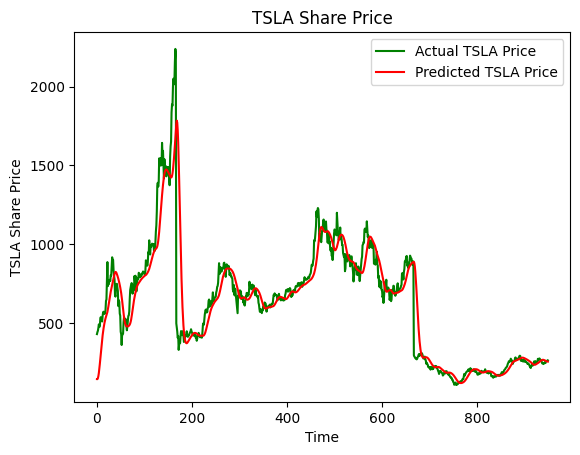

In [27]:
# Plot the test predictions
plt.plot(actual_prices, color='green', label=f"Actual {company} Price")
plt.plot(predicted_prices, color='red', label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [28]:
real_data=[model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]
real_data=np.array(real_data)
real_data=np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction=scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 1s 1s/step
Prediction: [[256.116]]


In [52]:
# Make predictions on the real data
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

# Get the actual price
actual_price = actual_prices[-1]

# Calculate the accuracy
accuracy = 100 - ((abs(actual_price - prediction[0][0]) / actual_price) * 100)

# Print company name, actual price, prediction price, and accuracy
print(f"Company: {company}")
print(f"Actual Price: {actual_price:.2f}")
print(f"Predicted Price: {prediction[0][0]:.2f}")
print(f"Accuracy: {accuracy:.2f}%")


1/1 [==============================] - 0s 138ms/step
Company: TSLA
Actual Price: 263.62
Predicted Price: 256.12
Accuracy: 97.15%
